<a href="https://colab.research.google.com/github/oumaima-arch/SOM-KMEANS/blob/main/TextDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install python-tr
!pip install opencv-python==4.2.0.32
#!pip install https://github.com/myhub/tr/archive/1.5.1.zip
!pip install nms
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip pillow
!pip install easyocr


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 62 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: unknown command "pillow"


In [2]:
## all imports
import numpy as np #Manipuler des matrices et tableaux multidimensionnels ainsi que des fonctions mathématiques opérant sur ces tableaux.
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#import os
from google.colab import drive
import cv2 #text detection
#from tr import * #operations sur les caracteres
#from PIL import Image, ImageDraw, ImageFont #Python Imaging Library : offrir un accès rapide aux données contenues dans une image
import nms #Non-maximum suppression Remove redundant bounding boxes in object detection
from imutils.object_detection import non_max_suppression
from google.colab.patches import cv2_imshow
import argparse
import time
from matplotlib import pyplot as plt #Tracer et visualiser des données sous formes de graphiques
from google.colab.patches import cv2_imshow
import pytesseract
import easyocr

In [9]:
#folder = drive.mount('/data')


Read Image:

In [3]:
im= cv2.imread('/content/1113-receipt.jpg')
if im is None:
  print('No such file!')
image = im.copy()

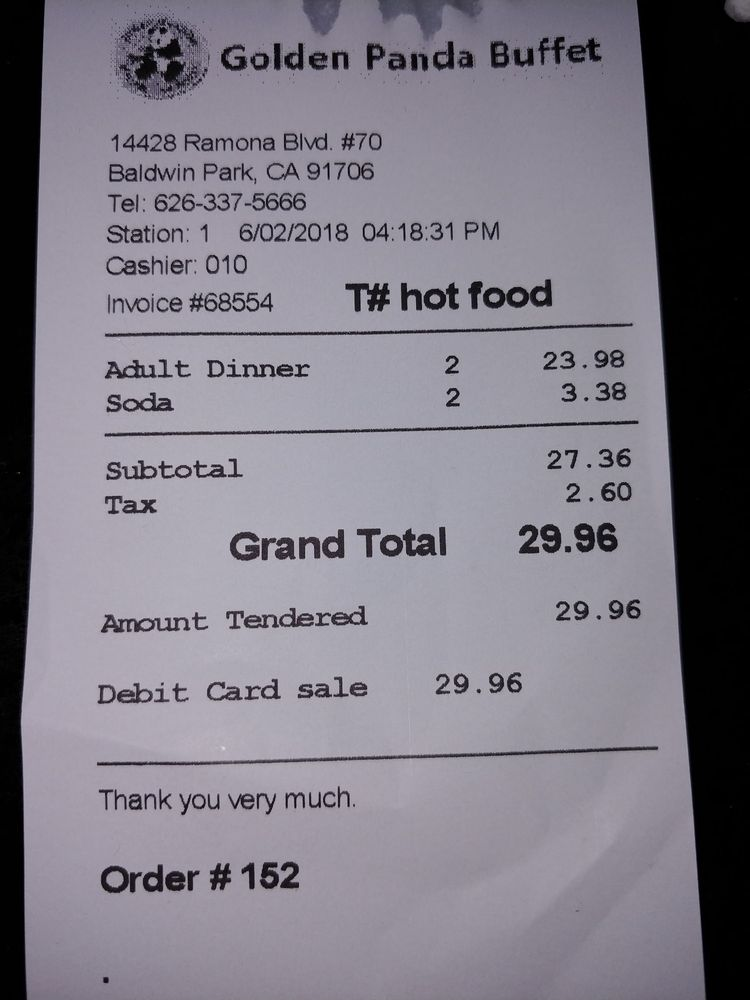

-1

In [4]:
# image height and width should be multiple of 32 (set the new height and width to default 320 )
imWidth=320
imHeight=320
#calculate the ratio between im and image for both height and weight 
#objecive : translate bounding box location on the original image (calculate ratio)
#image = im.copy()
(imageH, imageW) = im.shape[:2]
#returns a tuple of the number of rows, columns, and channels (if the image is color)
(newW,newH) = (imWidth, imHeight)
#ratio:
rW = imageW / float(newW)
rH = imageH / float(newH)
im = cv2.resize(im, (newW, newH)) #resize image
#size for output image: (imageH,imageW)
(imageH, imageW) = im.shape[:2]
cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
cv2_imshow(image)
cv2.waitKey(0)#to display a window for given milliseconds 

We will use cv2.dnn.ReadNet() function for loading the network into memory. It automatically detects configuration and framework based on file name specified. In our case, it is a pb file and thus, it will assume that a Tensorflow Network is to be loaded.

In [5]:
# East:
net = cv2.dnn.readNet('/content/frozen_east_text_detection.pb') #load EAST model for text detection 
# .pb : tensorflow
# Read deep learning network represented in one of the supported formats (returns net object)

We need to create a 4-D input blob for feeding the image to the network. using blobFromImage() function.

In [6]:
#create blob from image
blob = cv2.dnn.blobFromImage(im, 1.0, (imageW, imageH), (100.68, 97.78, 101.94), swapRB=True, crop=False)     #Creates 4-dimensional blob from series of images
#scaleFactor=1
#size for   output image: (imageW,imageH)
#scalar with mean values which are subtracted from channels. Values are intended to be in (mean-R, mean-G, mean-B) order if @p image has BGR ordering and @p swapRB is true.
#swapRBflag: which indicates that swap first and last channels in 3-channel image is necessary
#crop: flag which indicates whether image will be cropped after resize or not

We get the output by passing the input image through the network. As discussed earlier, the output consists of two parts : scores and geometry.

In [7]:
"""Defining output layers:
 We would like to get two outputs from the EAST model. 
1. Probabilty scores for the region whether that contains text or not. 
2. Geometry of the text -- Coordinates of the bounding box detecting a text"""
# The following two layer need to pulled from EAST model for achieving this. 
layerNames = ["feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"]

In [8]:
net.setInput(blob)
#Pass Input to Network and get the Ouput based on layers
(scores, geometry) = net.forward(layerNames) #Forward pass the blob from the image to get the desired output layers

In [9]:
## Returns a bounding box and probability score if it is more than minimum confidence
## Get rects and confidence score for bounding boxes
min_confidence=0.5
def predictions(prob_score, geo):
	(numR, numC) = prob_score.shape[2:4]
	boxes = []
	confidence_val = []

	# loop over rows
	for y in range(0, numR):
		scoresData = prob_score[0, 0, y]
		x0 = geo[0, 0, y]
		x1 = geo[0, 1, y]
		x2 = geo[0, 2, y]
		x3 = geo[0, 3, y]
		anglesData = geo[0, 4, y]

		# loop over the number of columns
		for i in range(0, numC):
			# if our score does not have sufficient probability, ignore it
			if scoresData[i] < min_confidence:
				continue
		  # compute the offset factor as our resulting feature maps will be 4x smaller than the input image
			(offX, offY) = (i * 4.0, y * 4.0)

			# extracting the rotation angle for the prediction and computing the sin and cos
			angle = anglesData[i]
			cos = np.cos(angle)
			sin = np.sin(angle)

			# using the geo volume to get the dimensions of the bounding box  # use the geometry volume to derive the width and height of the bounding box 
			h = x0[i] + x2[i]
			w = x1[i] + x3[i]

			# compute both the starting and ending (x, y) coordinates for the text prediction bounding box
			endX = int(offX + (cos * x1[i]) + (sin * x2[i]))
			endY = int(offY - (sin * x1[i]) + (cos * x2[i]))
			startX = int(endX - w)
			startY = int(endY - h)

      # add the bounding box coordinates and probability score to our respective lists
			boxes.append((startX, startY, endX, endY))
			confidence_val.append(scoresData[i])

			# return bounding boxes and associated confidence_val
			return (boxes, confidence_val)
 

In [10]:
# Find predictions and  apply non-maxima suppression to remove weak bounding boxes
(boxes, confidence_val) = predictions(scores, geometry)
boxes = non_max_suppression(np.array(boxes), probs=confidence_val)
# boxes:	A 2-D float Tensor of shape [num_boxes, 4].
# scores(probs):	A 1-D float Tensor of shape representing a single score corresponding to each row of boxes.

In [ ]:
#@title only one word !!!!
# Scale image back to original and create bounding boxes

# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
    # scale the bounding box coordinates based on the respective ratios
    startX = int(startX * rW)
    startY = int(startY * rH)
    endX = int(endX * rW)
    endY = int(endY * rH)

    # draw the bounding box on the image
    cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)

# show the output image
cv2_imshow(image)
cv2.waitKey(0)


In [15]:
# Providing the tesseract executable
# location to pytesseract library
path_to_tesseract="/content/tesseract-ocr-w64-setup-v5.1.0.20220510.exe"
pytesseract.tesseract_cmd = path_to_tesseract
# Passing the image object to image_to_string() function
text = pytesseract.image_to_string(image)
# Displaying the extracted text
print(text[:-1])

anda Buffet

 

14428 Ramona Blvd. #70

Baldwin Park, CA 91706

Tel: 626-337-5666

Station: 1 6/02/2018 04:18:31 PM
Cashier: 010

Invoice #68554 T# hot food

 

  
 

Adult Dinner Zz 23.98
Soda 2 3.38
SS Lee
Subtotal 27.36
Tax 2.60
Grand Total 29.96
29.96

Amount Tendered

Debit Card sale 29.96

a
Thank you very much.

Order # 152



CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:253: UserWarning: Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and will be removed in 0.15. Please access them via the appropriate Weights Enum instead.
  "Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and will "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `we

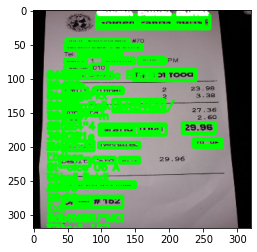

In [21]:

reader = easyocr.Reader(['en'])
result = reader.readtext(im)
result
top_left = tuple(result[0][0][0]) #tuple(): store multiple items in a single variable
bottom_right = tuple(result[0][0][2])
text = result[0][1]
font = cv2.FONT_HERSHEY_SIMPLEX

spacer = 100
for detection in result: 
    top_left = tuple(detection[0][0])
    bottom_right = tuple(detection[0][2])
    text = detection[1]
    im = cv2.rectangle(im,top_left,bottom_right,(0,255,0),3)
    im = cv2.putText(im,text,(20,spacer), font, 0.5,(0,255,0),2,cv2.LINE_AA)
    spacer+=15
    
plt.imshow(im)
plt.show()